In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)

# Define your custom palette as a list of hex codes
custom_palette = ['#FA6559', '#63C5DA','#343434']

# Set the palette to the custom palette
sns.set_palette(custom_palette)

# Now, all your Seaborn plots will use the colors from the custom palette you defined
sns.set_style("white")

In [2]:
#Reading up the dataframes
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/m5-forecasting-uncertainty/train_texas.csv")
test = pd.read_csv("/content/drive/MyDrive/m5-forecasting-uncertainty/test_texas.csv")

In [4]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [5]:
print(len(test))
print(len(df))

213430
1560823


# Feature engineering

In [6]:
import calendar

# Assuming 'df' is your DataFrame and contains 'year' and 'month' columns
# First, let's create a 'date' column assuming the first day of each month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Now we can define our functions
def get_week_number(x):
    """Get week number of particular date"""
    return x.isocalendar()[1]

def get_season(month):
    """Get season in US according to various months"""
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Applying the functions to create features
df['week_number'] = df['date'].apply(get_week_number)
df['season'] = df['month'].apply(get_season)

# Quarter and Month Start/End can be derived directly from the month
df['quarter_start'] = df['month'].isin([1, 4, 7, 10]).astype(int)
df['quarter_end'] = df['month'].isin([3, 6, 9, 12]).astype(int)
df['month_start'] = 1  # Since we're assuming the first day of the month
df['month_end'] = df['month'].isin([1, 3, 5, 7, 8, 10, 12]).astype(int)

# For year start and end, we can use the month
df['year_start'] = (df['month'] == 1).astype(int)
df['year_end'] = (df['month'] == 12).astype(int)

# Now drop the 'date' column if you don't need it anymore
df.drop(columns='date', inplace=True)



# Convert year and month to a datetime to represent the first day of the month
df['date'] = pd.to_datetime(df.assign(day=1)[['year', 'month', 'day']])

# Sort the DataFrame by 'id' and 'date' to ensure correct lag calculations
df.sort_values(by=['id', 'date'], inplace=True)

# Define the list of weeks for which to create lag features
weeks_lag = [4, 8, 16, 20, 24]

# Calculate lag features for the defined weeks
for lag_weeks in weeks_lag:
    lag_feature_name = 'sales_lag_weeks_' + str(lag_weeks)
    df[lag_feature_name] = df.groupby('id')['sales'].transform(lambda x: x.shift(lag_weeks))

# After creating lag features, you might want to remove rows with NaN values that were created due to shifting
lag_columns = ['sales_lag_weeks_' + str(lag_weeks) for lag_weeks in weeks_lag]
df.dropna(subset=lag_columns, inplace=True)

# Now df has the original columns plus the new lag features
print(df.head())

                              id   event_name_1 event_type_1  snap_TX  month  \
119  FOODS_1_001_TX_1_validation     Pesach End    Religious        0      4   
186  FOODS_1_001_TX_1_validation       no_event     no_event        0      4   
240  FOODS_1_001_TX_1_validation       no_event     no_event        1      4   
4    FOODS_1_001_TX_1_validation  Cinco De Mayo     Cultural        1      5   
56   FOODS_1_001_TX_1_validation    MemorialDay     National        0      5   

     year     sales  sell_price  count_holidays  CPI  week_number  season  \
119  2011  0.000000         2.0             2.0  NaN           13  Spring   
186  2011  0.222222         2.0             2.0  NaN           13  Spring   
240  2011  0.500000         2.0             2.0  NaN           13  Spring   
4    2011  1.000000         2.0             1.0  NaN           17  Spring   
56   2011  0.000000         2.0             1.0  NaN           17  Spring   

     quarter_start  quarter_end  month_start  month_end 

In [27]:
df.columns

Index(['id', 'event_name_1', 'event_type_1', 'snap_TX', 'month', 'year',
       'sales', 'sell_price', 'count_holidays', 'CPI', 'week_number', 'season',
       'quarter_start', 'quarter_end', 'month_start', 'month_end',
       'year_start', 'year_end', 'date', 'sales_lag_weeks_4',
       'sales_lag_weeks_8', 'sales_lag_weeks_16', 'sales_lag_weeks_20',
       'sales_lag_weeks_24'],
      dtype='object')

Model


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Data Preprocessing
# -------------------
categorical_columns = ['id', 'event_name_1', 'event_type_1', 'season']
continuous_columns = ['sell_price', 'count_holidays', 'CPI']  # Removed 'sales' as it's the target

# Assuming 'df' is your DataFrame
# Handle missing values
df[categorical_columns] = df[categorical_columns].fillna('Unknown')
df[continuous_columns] = df[continuous_columns].fillna(df[continuous_columns].mean())

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Normalize continuous variables
scaler = MinMaxScaler(feature_range=(0, 1))
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

# Feature and target separation
X = df.drop(columns=['sell_price', 'date'])  # Exclude 'date' from features
y = df['sell_price']

# Reshape data for LSTM model
timesteps = 8  # Choosing 8 to balance between capturing enough context and computational efficiency
X_lstm = np.array([X[i - timesteps:i].values for i in range(timesteps, len(X))])
y_lstm = y[timesteps:]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Model Architecture
# ------------------
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)),  # L2 regularization
    LeakyReLU(alpha=0.1),
    Dropout(0.2),  # Dropout for regularization
    LSTM(50, return_sequences=False, kernel_regularizer=l2(0.001)),  # Additional L2 regularization
    LeakyReLU(alpha=0.1),
    Dropout(0.2),  # Additional dropout layer
    Dense(1)
])

# Training Strategies
# -------------------
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Epoch 1/50
31113/31113 [==============================] - 166s 5ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 2/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/50
31113/31113 [==============================] - 158s 5ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 5/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6/50
31113/31113 [==============================] - 161s 5ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 9/50
31113/31113 [==============================] - 160s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 10/50
31113/31113 [=====================

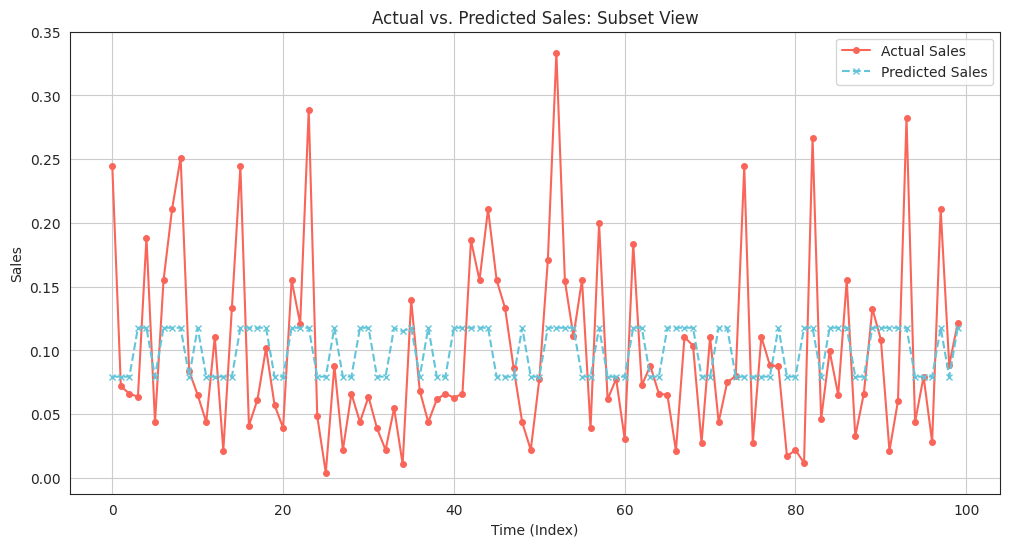

In [12]:
import matplotlib.pyplot as plt

# Ensure y_pred is a numpy array; if it's already an array, .flatten() will work directly
# For y_test, which is a pandas Series, convert it to numpy array if not already
actual_values = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
predicted_values = y_pred.flatten()

# Convert predictions and actual values to a pandas DataFrame for easier manipulation
results_df = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values})

# Plotting a subset of the predictions vs. actual values for clearer visibility
plt.figure(figsize=(12, 6))
plt.plot(results_df.index[:100], results_df['Actual'][:100], label='Actual Sales', marker='o', linestyle='-', markersize=4)
plt.plot(results_df.index[:100], results_df['Predicted'][:100], label='Predicted Sales', marker='x', linestyle='--', markersize=4)
plt.title('Actual vs. Predicted Sales: Subset View')
plt.xlabel('Time (Index)')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 50)             14600     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 50)             0         
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

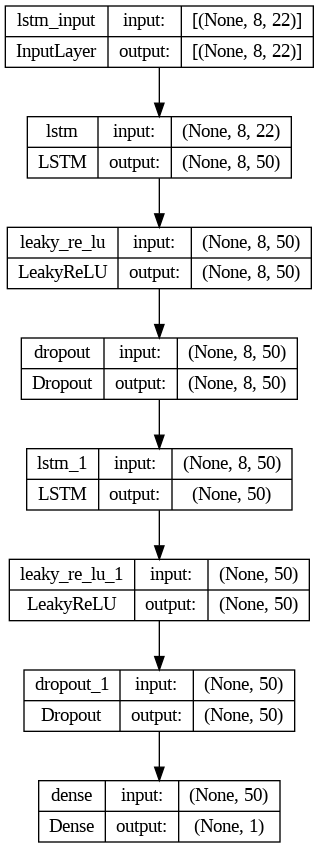

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)